In [67]:
#Second part of figure 3. the weight changes

import torch
import sys
import os
import io
from os.path import exists
import numpy as np
import pickle
from scipy.special import softmax
import json
from scipy import stats
import gzip, pickle, pickletools
import warnings
import glob
import copy

from scipy.signal import butter,filtfilt


from sklearn.linear_model import LinearRegression
from scipy.stats import ranksums, wilcoxon
import statsmodels.api as sm


import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.stats import ranksums, wilcoxon

from dynamics.utils import utils
from dynamics.vis import dynamics as dyplot


from dynamics.process.rnn import wt_kindergarten, wt_nets, wt_costs, wt_reinforce_cont_new, wt_pred, parse
from dynamics.vis import wt_vis
from dynamics.analysis import wt_analysis as wta
from dynamics.utils.utils import CPU_Unpickler,parse_configs, displ, memcheck, opsbase, mwa
from dynamics.analysis import state_analysis as sta
from dynamics.analysis import optim

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import interpolate
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
#%matplotlib notebook
#%matplotlib widget 
#out = widgets.Output(layout = widgets.Layout(height='300px'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#path info


kuse = [10,60,40]  # the maximum index for the final stage 5 and stage 6 training stage, by s_idx



dbase = '/scratch/dh148/dynamics/results/rnn/ac/20231003/'
# for figure 3
subdirlist = ['full_cl/', 'nok_cl/','nok_nocl/', 'full_cl_redo/', 'pkind_mem/', 'pkind_pred/']
# for supp. fig 3
#subdirlist = ['full_cl/', 'pkind_mem/', 'pkind_pred/', 'pkind_count/','pkind_int/']
configdir = lambda s_idx: '/home/dh148/projects/dynamics/jobs/20231003_clstudy/rnn/'+subdirlist[s_idx]
suff = '.json' #file ending
    
    
datadir_dat = lambda s_idx: dbase+subdirlist[s_idx]
fgen = lambda num,idx, base, sess, s_idx : datadir_dat(s_idx)+str(num)+'/'+base + str(num)+'_'+sess+'_'+str(idx)

fname_funs = [lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_kindergarten_' + str(num)+'_simple',
              lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_kindergarten_' + str(num)+'_int_0_'+str(idx),
              lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_pred_' + str(num)+'_'+str(idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'nocatch', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'catch', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'block', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'block', s_idx)+'_freeze'
             ]

configname_fun = lambda num, s_idx: configdir(s_idx) +str(num)+'.cfg'
fname_behdat_fun = lambda num,s_idx: datadir_dat(s_idx) + 'rnn_'+str(num)+'_allbeh.json'
fname_behdat_fun_1k = lambda num,s_idx: datadir_dat(s_idx) + 'rnn_'+str(num)+'_allbeh_1k.json'


In [3]:
def retrieve_behdat(fname_behdat, fname):
    """ helper code to lookup the dat in the behavioral data.
    if fname_behda is a list, just search it (for faster lookup)
    if a filename, load the file."""
    
    fname_base = fname.split('/')[-1]
    dat = None
    
    if type(fname_behdat) is list:  #easier to recylce
        datlist = fname_behdat
    else:
        #datlist = pickle.load(open(fname_behdat,'rb'))
        datlist = json.load(open(fname_behdat,'r'))
 
    for j in datlist:
        if j['name'] == fname_base:
            dat = j
            break
            
    return dat

In [5]:
#the weights
#output weights across training

#needops

def weight_outpt_acrosstraining(s_idx = 0, num = 0,n_int = 1, n_pred = 1):
    """
    gets the output projection across an entire set of training. does not include kindergarten 
    s_idx: CL type 0:full, 1:nok_cl, 2: nok_nocl, others are pkind?
    num: RNN number
    """
    
    device = torch.device('cpu')
    modeltype = 'RNNModel_multiregion_2allt'
    
    stagelist = []
    idxlist = []
    
    #lin sensitivity, wt ratio, historical regression, opt out, violation

    w_pred = []
    w_policy = []
    w_val = []
    w_rr =[]
    w_mem = []
    w_time = []
    w_str_rnn = []
    w_ofc_rnn = []
    w_str_inp = []
    w_ofc_inp = []
    
    fname_fun_stage = lambda stage, idx: fname_funs[stage](num, idx, s_idx)
    
    
    #find max int and pred in the directory
    #nmax_int = 5000
    #nmax_pred = 50
    nmax_simple = len(glob.glob(datadir_dat(s_idx)+str(num)+'/rnn_kindergarten_'+str(num)+'_simple.model'))
    nmax_int = len(glob.glob(datadir_dat(s_idx)+str(num)+'/rnn_kindergarten_'+str(num)+'_int*.model'))
    
    #set a maximum of 100 for this to avoid a runaway simulation
    
    nmax_pred = np.min([100,len(glob.glob(datadir_dat(s_idx)+str(num)+'/rnn_pred_'+str(num)+'*.model'))])
    
    #print([nmax_simple,nmax_int, nmax_pred])
    
    
    idxranges = [range(1,nmax_simple+1), range(1,nmax_int+1, n_int), range(1,nmax_pred+1, n_pred), 
                 range(1,11), range(1,11), range(1,61)]
    #idx of networks to pull for each portion of training
       
    
    #add in theinitialc ondition
    nd = wt_nets.netdict[modeltype]  # dictionary of models and size params
    netfun = nd['net']  
    netseed = num
    net = netfun(din=nd['din'], dout=nd['dout'], num_hiddens=[256,256], seed=netseed, rnntype='LSTM',
                 bias_init=0)
    
    stagelist.append(-1)
    idxlist.append(0)
    
    w_ofc = net.linear1.weight.detach().numpy()
    w_str = net.linear2.weight.detach().numpy()
    w_pred.append(w_ofc[0:3,:]) #predition
    w_policy.append(w_str[0:3,:]) #policies
    w_val.append(w_str[3,:])
    w_mem.append(w_str[4,:])
    w_time.append(w_str[5,:])
    w_rr.append(w_ofc[3,:])
    w_ofc_rnn.append(net.rnn1.weight_hh_l0.detach().numpy())
    w_str_rnn.append(net.rnn2.weight_hh_l0.detach().numpy())
    w_ofc_inp.append(net.rnn1.weight_ih_l0.detach().numpy())
    w_str_inp.append(net.rnn2.weight_ih_l0.detach().numpy())
    
    wnan = np.nan*net.rnn1.weight_hh_l0.detach().numpy()
    wnan_ofc_inp = np.nan*net.rnn1.weight_ih_l0.detach().numpy()
    wnan_str_inp = np.nan*net.rnn2.weight_ih_l0.detach().numpy()
    
    
    for stage in range(6):
    #for stage in [4,5,6]:
    
        for idx in idxranges[stage]:  
            
            #assume what is needed is in the stats. if not, do .dat files
            fname_model = fname_fun_stage(stage, idx)+ '.model'
            #print(fname_model)

            
            if exists(fname_model):
                
                try:
                
                    stagelist.append(stage)
                    idxlist.append(idx)

                    #load the model

                    nd = wt_nets.netdict[modeltype]  # dictionary of models and size params
                    netfun = nd['net']  
                    netseed = num
                    net = netfun(din=nd['din'], dout=nd['dout'], num_hiddens=[256,256], seed=netseed, rnntype='LSTM',
                                 bias_init=0)

                    net.load_state_dict(torch.load(fname_model, map_location=device.type))

                    w_ofc = net.linear1.weight.detach().numpy()
                    w_str = net.linear2.weight.detach().numpy()
                    w_pred.append(w_ofc[0:3,:]) #predition
                    w_policy.append(w_str[0:3,:]) #policies
                    w_val.append(w_str[3,:])
                    w_mem.append(w_str[4,:])
                    w_time.append(w_str[5,:])
                    w_rr.append(w_ofc[3,:])
                    w_ofc_rnn.append(net.rnn1.weight_hh_l0.detach().numpy())
                    w_str_rnn.append(net.rnn2.weight_hh_l0.detach().numpy())
                    w_ofc_inp.append(net.rnn1.weight_ih_l0.detach().numpy())
                    w_str_inp.append(net.rnn2.weight_ih_l0.detach().numpy())
                except:
                    print('issue: something might be up with .model file: '+fname_model)
                    #TODO: need to return some nans, becuase this is more of an issue than I thought
                    w_ofc_rnn.append(wnan)
                    w_str_rnn.append(wnan)
                    w_ofc_inp.append(wnan_ofc_inp)
                    w_str_inp.append(wnan_str_inp)
                


                        

                    
    d = {'w_pred':w_pred ,
    'w_mem':w_mem ,
    'w_time':w_time,
    'w_policy':w_policy ,
    'w_val':w_val ,
    'w_rr':w_rr,
    'w_ofc_rnn':w_ofc_rnn,
    'w_str_rnn':w_str_rnn,
    'w_ofc_inp':w_ofc_inp,
    'w_str_inp':w_str_inp}

                
    return d, stagelist, idxlist
                


In [51]:
#do a check to see if the initailization of networks is the same as some saved ones

device = torch.device('cpu')
modeltype = 'RNNModel_multiregion_2allt'

num = 3
s_idx = 0


nd = wt_nets.netdict[modeltype]  # dictionary of models and size params
netfun = nd['net']  
netseed = num
net = netfun(din=nd['din'], dout=nd['dout'], num_hiddens=[256,256], seed=netseed, rnntype='LSTM',
             bias_init=0)


w_ofc = net.linear1.weight.detach().numpy()


s_idx = 0
fname_fun_stage = lambda stage, idx: fname_funs[stage](num, idx, s_idx)
fname_init = fname_fun_stage(0, 0).split('rnn_')[0]+'rnn_init_'+str(num)+ '.model'

    
net.load_state_dict(torch.load(fname_init, map_location=device.type))
                
w_ofc_true = net.linear1.weight.detach().numpy()

print(w_ofc[0,0:20])
print(w_ofc_true[0,0:20])

[ 0.01938847  0.02319529 -0.03588345 -0.04444642 -0.05373296  0.00488897
  0.0184447  -0.01232195  0.05217092 -0.01136886 -0.02585177 -0.02835011
  0.04504063 -0.05842583 -0.04468738 -0.0093355  -0.01996568 -0.04710723
  0.05197722  0.03803706]
[ 0.01938847  0.02319529 -0.03588345 -0.04444642 -0.05373296  0.00488897
  0.0184447  -0.01232195  0.05217092 -0.01136886 -0.02585177 -0.02835011
  0.04504063 -0.05842583 -0.04468738 -0.0093355  -0.01996568 -0.04710723
  0.05197722  0.03803706]


In [6]:
#check these learning rates
lr_task = 0.0001
lr_kind = 0.0001
lr_pred = 0.005
base_epoch_kind = 1000
base_epcoh_pred = 20
base_epoch_task = 1000

r_task = base_epoch_task*lr_task
r_kind = base_epoch_kind*lr_kind
r_pred = base_epcoh_pred*lr_pred

n_int = int(r_task/r_kind) # grab model every 500 saves. did once per epoch
n_pred = int(r_task/r_pred)

print([n_int, n_pred])

[1, 1]


In [2]:
0.0001*1000
0.005*20

0.1

In [10]:
nnum = 26
d, stagelist, idxlist = weight_outpt_acrosstraining(num = nnum, s_idx = 1, n_int = n_int, n_pred = n_pred)
d['w_ofc_rnn'][1].shape

issue: something might be up with .model file: /scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/26/rnn_curric_26_block_24.model


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [117]:
#do over whole population

def acrossdat_weightchange(s_idx):
    print(s_idx)

    lenlist = []
    predlist_ofc = []
    predlist_str = []
    stagelist_list= []
    
    #max samples for each stage. 
    nm = [1, 9, 100, 10, 10, 60]
    if s_idx == 2:
        nn = 20
        print(nn)
    if s_idx < 2:
        nn = 50
    if s_idx > 2:
        nn = 10
    
    predmats_ofc = [np.nan*np.ones((nn,k)) for k in nm]
    predmats_str = [np.nan*np.ones((nn,k)) for k in nm]
    predmats_ofc_inp = [np.nan*np.ones((nn,k)) for k in nm]
    predmats_str_inp = [np.nan*np.ones((nn,k)) for k in nm]
    
    #predmat_str_simple = np.nan*np.ones(nn,nm[0])
    #predmat_str_int = np.nan*np.ones(nn,nm[1])
    #predmat_str_pred = np.nan*np.ones(nn,nm[2])
    #predmat_str_nocatch = np.nan*np.ones(nn,nm[3])
    #predmat_str_catch = np.nan*np.ones(nn,nm[4])
    #predmat_str_block = np.nan*np.ones(nn,nm[5])
    
    
    


    for j in range(1,nn+1):
        print(j,end='\r')
        nnum = j
        d, stagelist, idxlist = weight_outpt_acrosstraining(num = nnum, s_idx = s_idx, n_int=n_int, n_pred=n_pred)
          
        for k in range(6):
            #indices to use for this 
            idx_use = list(np.argwhere(np.array(stagelist)==k)[:,0])
            nidx = len(idx_use)
            #idx_use.insert(0,idx_use[0]-1)
            
            test = np.array([np.linalg.norm(d['w_ofc_rnn'][m]-d['w_ofc_rnn'][m-1]) for m in idx_use]) 
            predmats_ofc[k][j-1,:len(test)] = test
            test = np.array([np.linalg.norm(d['w_str_rnn'][m]-d['w_str_rnn'][m-1]) for m in idx_use]) 
            predmats_str[k][j-1,:len(test)] = test
            
            # TODO: add inputs for the supp fig
            test = np.array([np.linalg.norm(d['w_ofc_inp'][m]-d['w_ofc_inp'][m-1]) for m in idx_use]) 
            predmats_ofc_inp[k][j-1,:len(test)] = test
            test = np.array([np.linalg.norm(d['w_str_inp'][m]-d['w_str_inp'][m-1]) for m in idx_use]) 
            predmats_str_inp[k][j-1,:len(test)] = test
            
        predlist_ofc = np.concatenate(tuple(k for k in predmats_ofc),axis=1)
        predlist_str = np.concatenate(tuple(k for k in predmats_str),axis=1)
        predlist_ofc_inp = np.concatenate(tuple(k for k in predmats_ofc_inp),axis=1)
        predlist_str_inp = np.concatenate(tuple(k for k in predmats_str_inp),axis=1)

        
    return predlist_ofc, predlist_str, predlist_ofc_inp, predlist_str_inp



predlist_ofc_padded, predlist_str_padded, predlist_ofc_inp_padded, predlist_str_inp_padded = acrossdat_weightchange(s_idx = 0)
predlist_ofc_padded_nok_cl, predlist_str_padded_nok_cl, predlist_ofc_inp_padded_nok_cl, predlist_str_inp_padded_nok_cl = acrossdat_weightchange(s_idx = 1)
predlist_ofc_padded_nok_nocl, predlist_str_inp_padded_nok_nocl, predlist_ofc_inp_padded_nok_nocl, predlist_str_padded_nok_nocl = acrossdat_weightchange(s_idx = 2)


0
10
issue: something might be up with .model file: /scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/21/rnn_curric_21_block_24.model
issue: something might be up with .model file: /scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/26/rnn_curric_26_block_24.model
issue: something might be up with .model file: /scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/27/rnn_curric_27_block_23.model
issue: something might be up with .model file: /scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/28/rnn_curric_28_block_26.model
issue: something might be up with .model file: /scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/29/rnn_curric_29_block_5.model
issue: something might be up with .model file: /scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/29/rnn_curric_29_block_22.model
issue: something might be up with .model file: /scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/30/rnn_curric_30_block_8.model
issue: something might be up with .model file: /scratch/dh1

In [118]:
#save the lists?

savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'

with open(savedir+'weights_pop.dat','wb') as f:
    pickle.dump([[predlist_ofc_padded,predlist_str_padded,predlist_ofc_inp_padded,predlist_str_inp_padded, ],
                 [ predlist_ofc_padded_nok_cl, predlist_str_padded_nok_cl, predlist_ofc_inp_padded_nok_cl,predlist_str_inp_padded_nok_cl],
                [ predlist_ofc_padded_nok_nocl,predlist_str_inp_padded_nok_nocl, predlist_ofc_inp_padded_nok_nocl, predlist_str_padded_nok_nocl] ], f)

In [125]:
# time warp the prediction bit
predlens = [len(glob.glob(datadir_dat(0)+str(num)+'/rnn_pred_'+str(num)+'*.model')) for num in range(1,51)]

med_pred = np.floor(np.median(predlens)).astype(int)
print(med_pred)
ps_idx = 10
pe_idx_old = ps_idx + 100

predmesh_new = np.linspace(0,1,med_pred)




predlist = [predlist_ofc_padded,predlist_str_padded,predlist_ofc_inp_padded,predlist_str_inp_padded, 
            predlist_ofc_padded_nok_cl, predlist_str_padded_nok_cl, predlist_ofc_inp_padded_nok_cl,predlist_str_inp_padded_nok_cl,
            predlist_ofc_padded_nok_nocl,predlist_str_inp_padded_nok_nocl, predlist_ofc_inp_padded_nok_nocl, predlist_str_padded_nok_nocl]

predlist_new = []

iter =0

for m in predlist:
    print(iter)
    preddat_m = copy.deepcopy(m)
    print(len(preddat_m))
    
    pred_m = []

    for k in range(len(preddat_m)):
        test = list(preddat_m[k])

        clip_idx_base = np.argwhere(np.isnan(test))
        clip_idx = clip_idx_base[0,0]
        j = 0
        while clip_idx <= ps_idx: # find first instance where it is greater than 
            clip_idx = clip_idx_base[j,0]
            j+=1

        #extract old pred section
        pred_old = test[ps_idx:clip_idx]
        predmesh_old = np.linspace(0,1,clip_idx-ps_idx)
        #interpolate
        pred_new = np.interp(predmesh_new,predmesh_old,pred_old)
        # cut oold data
        [test.pop(ps_idx) for j in range(100)]  #keep popping old data as it hits that index
        # insert new data
        [test.insert(ps_idx+k, pred_new[k]) for k in range(len(pred_new))]


        pred_m.append(np.array(test))
    predlist_new.append(pred_m)
    iter +=1


30
0
50
1
50
2
50
3
50
4
50
5
50
6
50
7
50
8
20
9
20
10
20
11
20


In [137]:
dowarp = True
if dowarp:
    predlist_ofc_padded = np.array(predlist_new[0])
    predlist_str_padded = np.array(predlist_new[1]) 
    predlist_ofc_inp_padded = np.array(predlist_new[2])
    predlist_str_inp_padded = np.array(predlist_new[3])
    predlist_ofc_padded_nok_cl = np.array(predlist_new[4])
    predlist_str_padded_nok_cl = np.array(predlist_new[5])
    predlist_ofc_inp_padded_nok_cl = np.array(predlist_new[6])
    predlist_str_inp_padded_nok_cl = np.array(predlist_new[7])
    predlist_ofc_padded_nok_nocl = np.array(predlist_new[8])
    predlist_str_inp_padded_nok_nocl = np.array(predlist_new[9])
    predlist_ofc_inp_padded_nok_nocl = np.array(predlist_new[10])
    predlist_str_padded_nok_nocl = np.array(predlist_new[11])

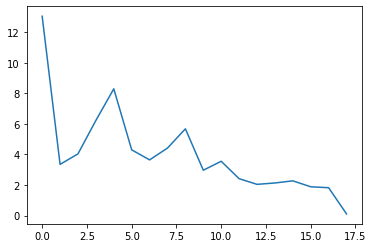

In [41]:

#plt.plot(predmesh_new,pred_new)

/state/partition1/job-40441228/ipykernel_2043246/1915752327.py:20: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_str_padded, axis=0)
/ext3/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/state/partition1/job-40441228/ipykernel_2043246/1915752327.py:24: RuntimeWarning: Mean of empty slice
  diffmean_nok_cl = np.nanmean(predlist_str_padded_nok_cl, axis=0)
/state/partition1/job-40441228/ipykernel_2043246/1915752327.py:27: RuntimeWarning: Mean of empty slice
  diffmean_nok_nocl = np.nanmean(predlist_str_padded_nok_nocl, axis=0)


(120,)


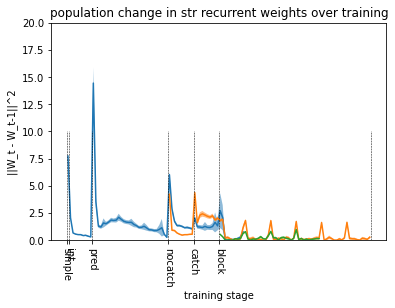

In [144]:
lmax = predlist_str_padded.shape[1]
lmax_nok_nocl = predlist_str_padded_nok_nocl.shape[1]
lmax_nok_cl = predlist_str_padded_nok_cl.shape[1]

#max samples for each stage. note how max number of samples from pred is 100? that matches the above constraint
if dowarp:
    nm = [0,1, 9, med_pred, 10, 10, 60]
    nm0 = [0, 1, 9, 10, 10, 10]
else:
    nm = [0,1, 9, 100, 10, 10, 60]
    nm0 = [0, 1, 9, 10, 10, 10]

#nm0 = [0, 1, 10, 10, 10, 10]

#lmax = sum(nm)
clstart = sum(nm[0:2])
noclstart = sum(nm[0:3])


diffmean = np.nanmean(predlist_str_padded, axis=0)
print(diffmean.shape)
diffsem = np.nanstd(predlist_str_padded, axis=0)/np.sqrt(20)

diffmean_nok_cl = np.nanmean(predlist_str_padded_nok_cl, axis=0)
diffsem_nok_cl = np.nanstd(predlist_str_padded_nok_cl, axis=0)/np.sqrt(20)

diffmean_nok_nocl = np.nanmean(predlist_str_padded_nok_nocl, axis=0)
diffsem_nok_nocl = np.nanstd(predlist_str_padded_nok_nocl, axis=0)/np.sqrt(20)

plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_cl)
plt.fill_between(range(lmax),diffmean_nok_cl-diffsem_nok_cl, diffmean_nok_cl+diffsem_nok_cl, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_nocl)
plt.fill_between(range(lmax),diffmean_nok_nocl-diffsem_nok_nocl, diffmean_nok_nocl+diffsem_nok_nocl, alpha = 0.5)

#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm[:-1])-0.5, labels = [stagedict[k] for k in range(len(nm)-1)], rotation = -90)
#plt.title('population change in prediction head weights over training')
#plt.title('population change in memory head weights over training')
#plt.title('population change in ofc recurrent weights over training')
plt.title('population change in str recurrent weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
#plt.xlim([0,28])
plt.ylim([0,20])

    
#plt.savefig(savedir+'str_weights_allcl.pdf')

plt.savefig(savedir+'str_weights_allcl_warped.pdf')
plt.show()

/state/partition1/job-40441228/ipykernel_2043246/755638.py:1: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_ofc_padded, axis=0)
/ext3/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/state/partition1/job-40441228/ipykernel_2043246/755638.py:4: RuntimeWarning: Mean of empty slice
  diffmean_nok_cl = np.nanmean(predlist_ofc_padded_nok_cl, axis=0)
/state/partition1/job-40441228/ipykernel_2043246/755638.py:7: RuntimeWarning: Mean of empty slice
  diffmean_nok_nocl = np.nanmean(predlist_ofc_padded_nok_nocl, axis=0)


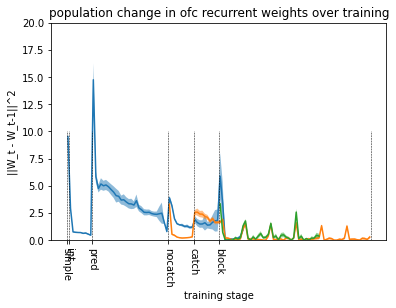

In [145]:
diffmean = np.nanmean(predlist_ofc_padded, axis=0)
diffsem = np.nanstd(predlist_ofc_padded, axis=0)/np.sqrt(20)

diffmean_nok_cl = np.nanmean(predlist_ofc_padded_nok_cl, axis=0)
diffsem_nok_cl = np.nanstd(predlist_ofc_padded_nok_cl, axis=0)/np.sqrt(20)

diffmean_nok_nocl = np.nanmean(predlist_ofc_padded_nok_nocl, axis=0)
diffsem_nok_nocl = np.nanstd(predlist_ofc_padded_nok_nocl, axis=0)/np.sqrt(20)

plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_cl)
plt.fill_between(range(lmax),diffmean_nok_cl-diffsem_nok_cl, diffmean_nok_cl+diffsem_nok_cl, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_nocl)
plt.fill_between(range(lmax),diffmean_nok_nocl-diffsem_nok_nocl, diffmean_nok_nocl+diffsem_nok_nocl, alpha = 0.5)

#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm[:-1])-0.5, labels = [stagedict[k] for k in range(len(nm)-1)], rotation = -90)
#plt.title('population change in prediction head weights over training')
#plt.title('population change in memory head weights over training')
#plt.title('population change in ofc recurrent weights over training')
plt.title('population change in ofc recurrent weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
#plt.xlim([0,28])
plt.ylim([0,20])

    
#plt.savefig(savedir+'ofc_weights_allcl.pdf')
plt.savefig(savedir+'ofc_weights_allcl_timewarped.pdf')
plt.show()

/state/partition1/job-40441228/ipykernel_2043246/3169362099.py:20: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_str_inp_padded, axis=0)
/ext3/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/state/partition1/job-40441228/ipykernel_2043246/3169362099.py:24: RuntimeWarning: Mean of empty slice
  diffmean_nok_cl = np.nanmean(predlist_str_inp_padded_nok_cl, axis=0)
/state/partition1/job-40441228/ipykernel_2043246/3169362099.py:27: RuntimeWarning: Mean of empty slice
  diffmean_nok_nocl = np.nanmean(predlist_str_inp_padded_nok_nocl, axis=0)


(120,)


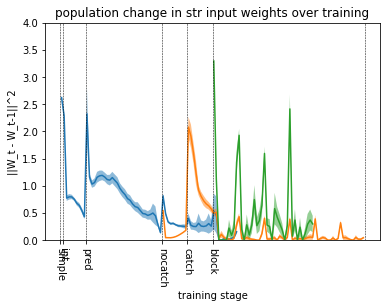

In [152]:
lmax = predlist_str_inp_padded.shape[1]
lmax_nok_nocl = predlist_str_inp_padded_nok_nocl.shape[1]
lmax_nok_cl = predlist_str_inp_padded_nok_cl.shape[1]

#max samples for each stage. note how max number of samples from pred is 100? that matches the above constraint
if dowarp:
    nm = [0,1, 9, med_pred, 10, 10, 60]
    nm0 = [0, 1, 9, 10, 10, 10]
else:
    nm = [0,1, 9, 100, 10, 10, 60]
    nm0 = [0, 1, 9, 10, 10, 10]

#nm0 = [0, 1, 10, 10, 10, 10]

#lmax = sum(nm)
clstart = sum(nm[0:2])
noclstart = sum(nm[0:3])


diffmean = np.nanmean(predlist_str_inp_padded, axis=0)
print(diffmean.shape)
diffsem = np.nanstd(predlist_str_inp_padded, axis=0)/np.sqrt(20)

diffmean_nok_cl = np.nanmean(predlist_str_inp_padded_nok_cl, axis=0)
diffsem_nok_cl = np.nanstd(predlist_str_inp_padded_nok_cl, axis=0)/np.sqrt(20)

diffmean_nok_nocl = np.nanmean(predlist_str_inp_padded_nok_nocl, axis=0)
diffsem_nok_nocl = np.nanstd(predlist_str_inp_padded_nok_nocl, axis=0)/np.sqrt(20)

plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_cl)
plt.fill_between(range(lmax),diffmean_nok_cl-diffsem_nok_cl, diffmean_nok_cl+diffsem_nok_cl, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_nocl)
plt.fill_between(range(lmax),diffmean_nok_nocl-diffsem_nok_nocl, diffmean_nok_nocl+diffsem_nok_nocl, alpha = 0.5)

#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm[:-1])-0.5, labels = [stagedict[k] for k in range(len(nm)-1)], rotation = -90)
plt.title('population change in str input weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
#plt.xlim([0,28])
plt.ylim([0,4])

    
#plt.savefig(savedir+'str_weights_allcl.pdf')

plt.savefig(savedir+'str_weights_allcl_inp_warped.pdf')
plt.show()

/state/partition1/job-40441228/ipykernel_2043246/1126363717.py:1: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_ofc_inp_padded, axis=0)
/ext3/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/state/partition1/job-40441228/ipykernel_2043246/1126363717.py:4: RuntimeWarning: Mean of empty slice
  diffmean_nok_cl = np.nanmean(predlist_ofc_inp_padded_nok_cl, axis=0)
/state/partition1/job-40441228/ipykernel_2043246/1126363717.py:7: RuntimeWarning: Mean of empty slice
  diffmean_nok_nocl = np.nanmean(predlist_ofc_inp_padded_nok_nocl, axis=0)


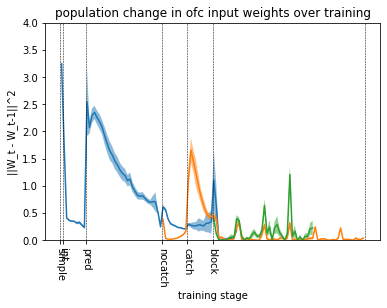

In [151]:
diffmean = np.nanmean(predlist_ofc_inp_padded, axis=0)
diffsem = np.nanstd(predlist_ofc_inp_padded, axis=0)/np.sqrt(20)

diffmean_nok_cl = np.nanmean(predlist_ofc_inp_padded_nok_cl, axis=0)
diffsem_nok_cl = np.nanstd(predlist_ofc_inp_padded_nok_cl, axis=0)/np.sqrt(20)

diffmean_nok_nocl = np.nanmean(predlist_ofc_inp_padded_nok_nocl, axis=0)
diffsem_nok_nocl = np.nanstd(predlist_ofc_inp_padded_nok_nocl, axis=0)/np.sqrt(20)

plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_cl)
plt.fill_between(range(lmax),diffmean_nok_cl-diffsem_nok_cl, diffmean_nok_cl+diffsem_nok_cl, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_nocl)
plt.fill_between(range(lmax),diffmean_nok_nocl-diffsem_nok_nocl, diffmean_nok_nocl+diffsem_nok_nocl, alpha = 0.5)

#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm[:-1])-0.5, labels = [stagedict[k] for k in range(len(nm)-1)], rotation = -90)
#plt.title('population change in prediction head weights over training')
#plt.title('population change in memory head weights over training')
#plt.title('population change in ofc recurrent weights over training')
plt.title('population change in ofc input weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
#plt.xlim([0,28])
plt.ylim([0,4])

    
#plt.savefig(savedir+'ofc_weights_allcl.pdf')
plt.savefig(savedir+'ofc_weights_allcl_inp_timewarped.pdf')
plt.show()